<a href="https://colab.research.google.com/github/muksmuks/computer_vision/blob/master/project_12/W12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

#####Enable Eager execution

In [0]:
tf.enable_eager_execution()

####Hyperparameters

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

https://mc.ai/tutorial-1-cifar10-with-google-colabs-free-gpu%E2%80%8A-%E2%80%8A92-5/

####Initialize the weights/parameters just like Pytorch
Initialization function now returns a NumPy array for eager execution.

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

####Davidnet Architecture
![David Net](https://cdn-images-1.medium.com/freeze/max/1000/1*uKqdR2jn83pOhTEMLHQpJQ.png?q=20)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.drop = tf.keras.layers.Dropout(0.05)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.drop(self.conv(inputs))))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

####Load and preprocess the cifar10 dataset
cifar10 images are 32x32

1. Pad the train images with 4px on each side, so that the image size becomes 40x40. (mode='reflect' ~ Pads with the reflection of the vector mirrored on the first and last values of the vector along each axis.)
2. Do batch normalization

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
model = DavidNet()

In [0]:
batches_per_epoch = len_train//BATCH_SIZE + 1

####Learning Schedule
Learning rate schedule in which the learning rate is updating during training according to some specified rule.

In [0]:
lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
#No of iterations/batches seen so far
global_step = tf.train.get_or_create_global_step()
###global_step/iterations_per_epoch gives the epoch ,it is in
###Use the lr_schedule to get the extrapolated values
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE

Text(0, 0.5, 'Learning Rate')

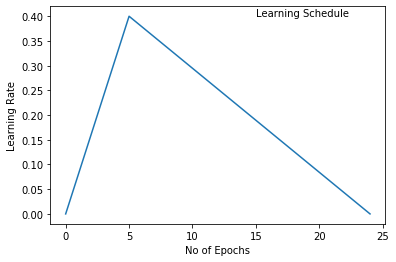

In [24]:
from matplotlib import pyplot as plt

p = plt.plot([0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])
plt.text(15, 0.4, "Learning Schedule")
plt.xlabel("No of Epochs")
plt.ylabel("Learning Rate")

####Optimizer

In [0]:
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

####Data Augmentation
1. Do a random crop so that the image size is 32x32, same as cifar10 image size
2. Randomly flip an image horizontally (left to right). y is the seed value

This would make the model robust and prevent from overfitting

In [0]:
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

####Training
The fit or fit_generator calls are not used for training.

GradientTape records the forward pass gradient computations
In the back propagation step the recorded values are used to update the trainable parameters.
Final data is printed in a formatted output. TQDM module provides a nice progress bar indication.

In [18]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.6242557904052735 train acc: 0.4115 val loss: 1.1655838928222657 val acc: 0.5841 time: 43.35936760902405



epoch: 2 lr: 0.16 train loss: 0.8867128491210937 train acc: 0.68642 val loss: 0.8291747970581055 val acc: 0.7225 time: 72.16898107528687



epoch: 3 lr: 0.24 train loss: 0.6647884490966797 train acc: 0.76846 val loss: 1.1889152709960937 val acc: 0.6557 time: 101.03358745574951



epoch: 4 lr: 0.32 train loss: 0.5692458438110352 train acc: 0.80234 val loss: 0.8238794799804687 val acc: 0.7291 time: 130.01852345466614



epoch: 5 lr: 0.4 train loss: 0.5131099627685547 train acc: 0.82408 val loss: 0.6833686828613281 val acc: 0.7809 time: 159.07214641571045



epoch: 6 lr: 0.37894736842105264 train loss: 0.4182494326782227 train acc: 0.85674 val loss: 0.5184402328491211 val acc: 0.8239 time: 188.01205778121948



epoch: 7 lr: 0.35789473684210527 train loss: 0.3462485992431641 train acc: 0.87914 val loss: 0.6897410263061523 val acc: 0.783 time: 217.00951433181763



epoch: 8 lr: 0.33684210526315794 train loss: 0.3019173915100098 train acc: 0.89474 val loss: 0.39102679290771486 val acc: 0.871 time: 245.657568693161



epoch: 9 lr: 0.31578947368421056 train loss: 0.26032614440917967 train acc: 0.9099 val loss: 0.36541075439453125 val acc: 0.8755 time: 274.4259204864502



epoch: 10 lr: 0.2947368421052632 train loss: 0.22718321548461914 train acc: 0.92174 val loss: 0.3325640899658203 val acc: 0.8886 time: 303.18052411079407



epoch: 11 lr: 0.2736842105263158 train loss: 0.19937638687133788 train acc: 0.93074 val loss: 0.40616001739501956 val acc: 0.878 time: 331.8529431819916



epoch: 12 lr: 0.25263157894736843 train loss: 0.17945043281555176 train acc: 0.9376 val loss: 0.34952618560791016 val acc: 0.8911 time: 360.78307127952576



epoch: 13 lr: 0.23157894736842108 train loss: 0.15687247940063476 train acc: 0.9458 val loss: 0.32603763656616214 val acc: 0.8962 time: 389.6722650527954



epoch: 14 lr: 0.2105263157894737 train loss: 0.13960301528930663 train acc: 0.95124 val loss: 0.3150031341552734 val acc: 0.898 time: 418.47191882133484



epoch: 15 lr: 0.18947368421052635 train loss: 0.1215735237121582 train acc: 0.9572 val loss: 0.3138913215637207 val acc: 0.9049 time: 447.37875866889954



epoch: 16 lr: 0.16842105263157897 train loss: 0.1070218357849121 train acc: 0.96282 val loss: 0.33923285217285154 val acc: 0.8992 time: 476.42308592796326



epoch: 17 lr: 0.1473684210526316 train loss: 0.0898905020904541 train acc: 0.9696 val loss: 0.3117131134033203 val acc: 0.9011 time: 505.18851590156555



epoch: 18 lr: 0.12631578947368421 train loss: 0.07830657676696777 train acc: 0.97428 val loss: 0.3008590057373047 val acc: 0.9104 time: 534.1336109638214



epoch: 19 lr: 0.10526315789473689 train loss: 0.06948649604797363 train acc: 0.97708 val loss: 0.2761876285552978 val acc: 0.9189 time: 562.6530432701111



epoch: 20 lr: 0.08421052631578951 train loss: 0.05879084957122803 train acc: 0.98104 val loss: 0.2755186965942383 val acc: 0.9195 time: 591.4901742935181



epoch: 21 lr: 0.06315789473684214 train loss: 0.05019992988586426 train acc: 0.9846 val loss: 0.26473819427490236 val acc: 0.9217 time: 620.3184950351715



epoch: 22 lr: 0.04210526315789476 train loss: 0.04178289047241211 train acc: 0.9874 val loss: 0.25552871551513673 val acc: 0.9258 time: 649.155341386795



epoch: 23 lr: 0.02105263157894738 train loss: 0.03780493816375732 train acc: 0.9886 val loss: 0.2482700782775879 val acc: 0.9277 time: 677.8685238361359



epoch: 24 lr: 0.0 train loss: 0.03248236795425415 train acc: 0.99132 val loss: 0.24684863510131835 val acc: 0.9282 time: 706.6500709056854


####Accuracy

Validation Accuracy 92.82 in 706.6500709056854 seconds